In [77]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from dateutil.relativedelta import relativedelta

import mysql.connector

import gcGroupbyExtension

from config import Cfg as cfg

%matplotlib inline

## Race results

In [78]:
cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)

query = "SELECT * FROM results;"

# execute the query and assign it to a pandas dataframe
df_results = pd.read_sql(query, con=cnx)

cnx.close()

## Races info

In [79]:
cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)

query = "SELECT * FROM races;"
# execute the query and assign it to a pandas dataframe
df_races = pd.read_sql(query, con=cnx)

cnx.close()

### Some processing on the datasets

In [84]:
# -----------
# -- RACES --
# -----------

# keep only active races
df_races = df_races.loc[df_races['info'].dropna().index]

# -----------
# -- RESULTS --
# -----------

# keep only results of non discontinued races
df_results = df_results[df_results['racename'].isin(df_races['racename'])]

# extract gender from division
df_results['gender'] = df_results['division'].apply(lambda x: x[0])

# convert date to datetime
df_results['date'] = pd.to_datetime(df_results['date'])

# add year specific info
df_results['date_year'] = df_results['date'].apply(lambda x: x.year)

# discard pro athletes
df_results = df_results.loc[df_results.division.str.contains("PRO") == False]

### what do we have left to work with?

In [85]:
print('-- Results dataset --')
print(f"  Number of single results: {len(df_results)}")
print(f"  Number of athletes: {len(df_results.athlete.unique())}")

print('-- Races dataset --')
print(f"  Number of active races: {len(df_races)}")

-- Results dataset --
  Number of single results: 1582516
  Number of athletes: 577916
-- Races dataset --
  Number of active races: 160


## Add Race count per athlete

In [86]:
# query = '''SELECT *
# FROM (
#          SELECT athlete, count(*) as count_races
#          FROM results
#          GROUP BY athlete
#      ) as t1
# ORDER BY count_races DESC'''

# cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)
# athletes_race_count = pd.read_sql(query, con=cnx)
# cnx.close()

athletes_race_count = (df_results.groupby('athlete')['division']
     .count()
     .reset_index()
     .rename(columns={'division': 'number_of_races'})
     .sort_values(by="number_of_races", ascending=False)
)

athletes_race_count.head(10)

,athlete,number_of_races
522828,Taiwan Triathlete,686
131844,David Smith,165
387695,Michael Smith,157
129146,David Jones,153
490215,Scott Smith,132
267167,John Wragg,130
69240,Brian Smith,122
32182,Andrew Smith,114
382336,Michael Brown,114
360258,Mark Smith,110


The `Taiwan Thriathlete` is what the iRonMan website entered for every Taiwainese athlete ... and then there are probably several David Smith, Michael Smith, etc ... need to find a solution to isolated each one. Maybe using age group?

In [122]:
final_df_results = df_results.merge(athletes_race_count, left_on="athlete", right_on="athlete", how="left")
final_df_results.head(5)

,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,country,date,fulldata,score,swim_score,run_score,bike_score,gender,date_year,number_of_races
0,1518207,Al Tarkington,M75-79,1,1073,1209,2440,678,11150,469,...,USA,2016-11-13,0,98.4,100.0,86.1,100.0,M,2016,10
1,1518209,Tadashi Horiuchi,M75-79,2,1141,1301,3539,679,13127,461,...,JPN,2016-11-13,0,97.1,77.2,100.0,90.7,M,2016,8
2,1518210,Graham Crocker,M65-69,1,181,202,1895,377,9944,243,...,AUS,2016-11-13,0,99.9,100.0,100.0,99.7,M,2016,25
3,1518211,Satoshi Tomita,M80-84,1,1281,1475,3135,784,13528,726,...,JPN,2016-11-13,0,100.0,100.0,100.0,100.0,M,2016,5
4,1518213,Ignacio Herrero,M55-59,1,134,152,2150,350,9711,282,...,ESP,2016-11-13,0,99.6,100.0,98.3,99.0,M,2016,8


#### Let's get rid of anyone that has more than 100 races. We cannot really trust those data

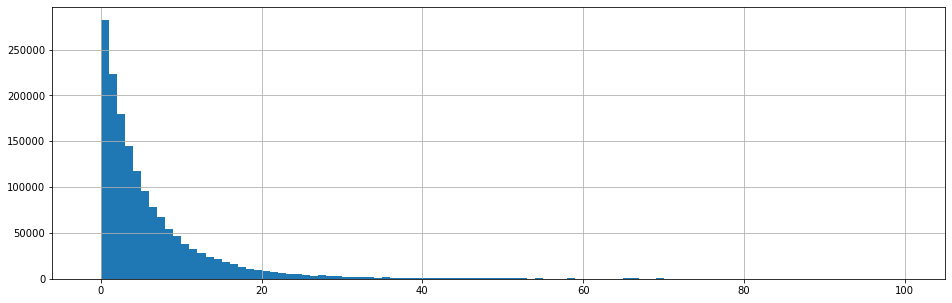

In [123]:
final_df_results = final_df_results.loc[final_df_results['number_of_races']<=100]

final_df_results['number_of_races'].hist(bins=np.arange(-0.99, 100.99, 1), figsize=(16, 5))

A majority of athletes have < 20 races

## We need to make a `profile` for each athlete. What features could we extract from the data we have?

## Years in sport

In [124]:
years_in_sport = (final_df_results
     .groupby('athlete')
     .pipe(lambda g: ((g.date.max()-g.date.min()).astype('timedelta64[Y]'))+1) # add 1 so if only one race will be 1 year
     .rename('years_in_sport') 
)

final_df_results = final_df_results.merge(years_in_sport, left_on="athlete", right_on="athlete", how="left")
final_df_results['years_in_sport'] = final_df_results.years_in_sport.astype(int)
final_df_results.head(5)

,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,date,fulldata,score,swim_score,run_score,bike_score,gender,date_year,number_of_races,years_in_sport
0,1518207,Al Tarkington,M75-79,1,1073,1209,2440,678,11150,469,...,2016-11-13,0,98.4,100.0,86.1,100.0,M,2016,10,7
1,1518209,Tadashi Horiuchi,M75-79,2,1141,1301,3539,679,13127,461,...,2016-11-13,0,97.1,77.2,100.0,90.7,M,2016,8,9
2,1518210,Graham Crocker,M65-69,1,181,202,1895,377,9944,243,...,2016-11-13,0,99.9,100.0,100.0,99.7,M,2016,25,13
3,1518211,Satoshi Tomita,M80-84,1,1281,1475,3135,784,13528,726,...,2016-11-13,0,100.0,100.0,100.0,100.0,M,2016,5,13
4,1518213,Ignacio Herrero,M55-59,1,134,152,2150,350,9711,282,...,2016-11-13,0,99.6,100.0,98.3,99.0,M,2016,8,5


## Active years in sport

In [173]:
active_years = (
    final_df_results
        .groupby(['athlete', 'date_year'])
        .size()
        .reset_index()
        .groupby('athlete')
        .size()
        .rename("active_years_in_sport")
)

final_df_results = final_df_results.merge(active_years, left_on="athlete", right_on="athlete", how="left")
final_df_results.head()

,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,fulldata,score,swim_score,run_score,bike_score,gender,date_year,number_of_races,years_in_sport,active_years_in_sport
0,1518207,Al Tarkington,M75-79,1,1073,1209,2440,678,11150,469,...,0,98.4,100.0,86.1,100.0,M,2016,10,7,6
1,1518209,Tadashi Horiuchi,M75-79,2,1141,1301,3539,679,13127,461,...,0,97.1,77.2,100.0,90.7,M,2016,8,9,5
2,1518210,Graham Crocker,M65-69,1,181,202,1895,377,9944,243,...,0,99.9,100.0,100.0,99.7,M,2016,25,13,13
3,1518211,Satoshi Tomita,M80-84,1,1281,1475,3135,784,13528,726,...,0,100.0,100.0,100.0,100.0,M,2016,5,13,4
4,1518213,Ignacio Herrero,M55-59,1,134,152,2150,350,9711,282,...,0,99.6,100.0,98.3,99.0,M,2016,8,5,5


## Avg number of race per active year

In [175]:
final_df_results['avg_n_races_year'] = final_df_results['number_of_races']/final_df_results['active_years_in_sport']
final_df_results.head()

,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,score,swim_score,run_score,bike_score,gender,date_year,number_of_races,years_in_sport,active_years_in_sport,avg_n_races_year
0,1518207,Al Tarkington,M75-79,1,1073,1209,2440,678,11150,469,...,98.4,100.0,86.1,100.0,M,2016,10,7,6,1.666667
1,1518209,Tadashi Horiuchi,M75-79,2,1141,1301,3539,679,13127,461,...,97.1,77.2,100.0,90.7,M,2016,8,9,5,1.600000
2,1518210,Graham Crocker,M65-69,1,181,202,1895,377,9944,243,...,99.9,100.0,100.0,99.7,M,2016,25,13,13,1.923077
3,1518211,Satoshi Tomita,M80-84,1,1281,1475,3135,784,13528,726,...,100.0,100.0,100.0,100.0,M,2016,5,13,4,1.250000
4,1518213,Ignacio Herrero,M55-59,1,134,152,2150,350,9711,282,...,99.6,100.0,98.3,99.0,M,2016,8,5,5,1.600000


In [ ]:
# percentage of race that don't overlap
# goes to races abroad?

In [89]:
# test for a specific athlete
test_athlete = final_df_results.loc[final_df_results.athlete == final_df_results.athlete.unique()[5]]

# # resample results per years
test_athlete_years = test_athlete.resample('Y', on='date')

#### Number of race per year

In [10]:
athl_count_year = test_athlete_years['id'].count()
athl_count_year

date
2011-12-31    1
2012-12-31    1
2013-12-31    1
2014-12-31    2
2015-12-31    2
2016-12-31    4
2017-12-31    1
Freq: A-DEC, Name: id, dtype: int64

Do people have same pattern?

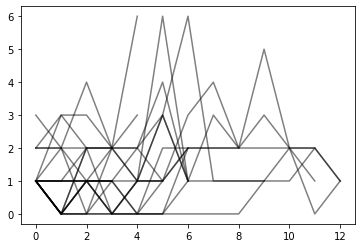

In [11]:
fig,ax = plt.subplots()

for i in range(20):
    ax.plot(
        final_df_results.loc[final_df_results.athlete == final_df_results.athlete.unique()[i]]
            .resample('Y', on='date')['id']
            .count().values,
        color="k",
        alpha=0.5
    )

#### Time in the sport

In [12]:
from dateutil.relativedelta import relativedelta

timespan = test_athlete_years['id'].count().index
relativedelta(timespan[-1], timespan[0]).years+1

7

#### Average number of race per year athlete has raced (can account for injury)

In [13]:
filtered_count = athl_count_year[athl_count_year != 0]
filtered_count.mean()

1.7142857142857142

#### Indicator of uniqueness in race choice ? (Lots of redundancy in races or lots of differente races?)

1 = all races are uniques
close to zero is lots of overlap

In [14]:
# percentage of race that don't overlap
len(test_athlete.racename.unique()) / len(test_athlete) 

0.5833333333333334

### Goes to races abroad?

In [15]:
# cross link with race data table
races_regions = []
for racename in test_athlete.racename.unique():
    region = df_races.loc[df_races.racename == racename].region.values
    if (len(region)>0 and region[0]!=''):
        races_regions.append(region)
np.unique(races_regions)

array(['Asia', 'Europe', 'North America'], dtype=object)

In [59]:
years_in_sport = (final_df_results
     .groupby('athlete')
     .pipe(lambda g: (g.date.max()-g.date.min()).astype('timedelta64[Y]'))
)

In [76]:
races_per_year = (final_df_results.iloc[:1]
     .groupby('athlete')
     .pipe(lambda g: g['date'])
)

for g,dg in final_df_results.iloc[:1].groupby('athlete'):
    print(dg.date.apply(lambda x: x.year))

0    2016
Name: date, dtype: int64


In [51]:
athl_max = years_in_sport.loc[years_in_sport == years_in_sport.max()]

In [54]:
athl_max.index[0]

'Agnes Safford'

In [68]:
final_df_results.loc[final_df_results.athlete == athl_max.index[0]]['date'].apply(lambda x: x.year)

222459     2015
517899     2013
613513     2012
961408     2005
1051599    2003
1539286    2019
1556188    2019
Name: date, dtype: int64

In [142]:
final_df_results['time_in_sport'] = None 
final_df_results['nRaces_years_avg'] = None 
final_df_results['nRaces_years_median'] = None 
final_df_results['race_uniqueness_coef'] = None 
final_df_results['races_regions'] = None 
final_df_results['races_regions_number'] = None 

for i,athlete in enumerate(final_df_results.athlete.unique().tolist()):
    athlete_data = final_df_results.loc[final_df_results.athlete == athlete]
    # resample results per years
    athlete_data_years = athlete_data.resample('Y', on='date')
    # number of race per year
    athlete_count_year = athlete_data_years['id'].count()
    # time in the sport
    timespan = athlete_count_year.index
    time_in_sport = relativedelta(timespan[-1], timespan[0]).years+1
    # average/median number of race per active year
    avg_n_race_year = athlete_count_year[athlete_count_year != 0].mean()
    median_n_race_year = athlete_count_year[athlete_count_year != 0].median()
    # percentage of race that don't overlap
    uniqueness_coef = len(athlete_data.racename.unique()) / len(athlete_data) 
    # cross link with race data table
    races_regions = []
    for racename in athlete_data.racename.unique().tolist():
        region = df_races.loc[df_races.racename == racename].region.values
        if (len(region)>0 and region[0]!=''):
            toAdd = region[0]
            if (toAdd):
                races_regions.append(region[0])
    try:
        all_regions = np.unique(races_regions).tolist()
    except:
        print(races_regions)
    
    # fill in the data
    final_df_results.loc[final_df_results.athlete ==  athlete, [
        'time_in_sport', 
        'nRaces_years_avg',
        'nRaces_years_median',
        'race_uniqueness_coef',
        'races_regions',
        'races_regions_number'
    ]] = [time_in_sport,
          avg_n_race_year,
          median_n_race_year,
          uniqueness_coef,
          f"{all_regions}",
          len(all_regions)
         ]


    if (i%1000 == 0):
        print(f"-- {i} athletes done!")
    

-- 0 athletes done!
-- 1000 athletes done!


KeyboardInterrupt: 

In [143]:
final_df_results.loc[final_df_results.time_in_sport != None]

,id,athlete,division,rankdiv,rankgender,rankoverall,swim,t1,bike,t2,...,run_score,bike_score,gender,number_of_races,time_in_sport,nRaces_years_avg,nRaces_years_median,race_uniqueness_coef,races_regions,races_regions_number
0,1518207,Al Tarkington,M75-79,1,1073,1209,2440,678,11150,469,...,86.1,100.0,M,10,7,1.66667,2,0.7,"['Asia', 'Australia', 'North America', 'South ...",4
1,1518209,Tadashi Horiuchi,M75-79,2,1141,1301,3539,679,13127,461,...,100.0,90.7,M,8,9,1.6,2,0.625,"['Asia', 'Australia', 'North America']",3
2,1518210,Graham Crocker,M65-69,1,181,202,1895,377,9944,243,...,100.0,99.7,M,25,13,1.92308,2,0.48,"['Asia', 'Australia', 'Europe']",3
3,1518211,Satoshi Tomita,M80-84,1,1281,1475,3135,784,13528,726,...,100.0,100.0,M,5,13,1.25,1,1,"['Asia', 'Australia', 'Europe', 'North America']",4
4,1518213,Ignacio Herrero,M55-59,1,134,152,2150,350,9711,282,...,98.3,99.0,M,8,6,1.6,2,0.75,"['Africa', 'Asia', 'Europe', 'North America']",4
5,1518214,Jonas Mosimann,M18-24,1,67,77,2240,233,9166,174,...,98.9,98.0,M,12,7,1.71429,1,0.583333,"['Asia', 'Europe', 'North America']",3
6,1518215,Jinduo Pei,M65-69,2,270,302,2662,389,9964,262,...,98.8,99.6,M,4,4,1,1,0.75,['Asia'],1
7,1518218,Nobuyuki Tanaka,M60-64,1,194,215,2219,346,9625,240,...,99.2,100.0,M,19,7,2.71429,2,0.578947,"['Asia', 'Australia', 'Europe', 'North America']",4
8,1518219,Stefan Duller,M45-49,1,20,22,2284,286,8270,195,...,101.1,101.3,M,11,13,1.1,1,0.545455,"['Asia', 'Europe', 'North America']",3
9,1518220,Roger Canham,M50-54,1,29,33,2145,299,8742,190,...,50.0,96.5,M,22,12,1.83333,1.5,0.818182,"['Africa', 'Asia', 'Australia', 'Europe', 'Nor...",5
